# Diving into Random Matrix Theory (RMT)


### Random symmetric matrix (Furedi & Komlos)

A = ($a_{ij}$) is an n$\times$n matrix whose entries for i$\ge$j are independent random variables and $a_{ji} = a_{ij}$.

For every i > j, $\mathbb{E} a_{ij}$ = $\mu$, $\mathbb{D}^2 a_{ij}$ = $\sigma^2$ and $\mathbb{E} a_{ii}$ = $\nu$.

For any c > 2 $\sigma$ with the probability 1 - o(1), all eigenvalues except for at most o(n) lie in the interval $\mathcal{I} = (- c \sqrt{n}, c \sqrt{n}$).

If $\mu$ = 0, with the probability 1 - o(1), all eigenvalues belong to $\mathcal{I}$.

While $\mu$ > 0, only the largest eigenvalues $\lambda_1$ is outside $\mathcal{I}$.

### Eigenvalues distribution for some symmetric class of Hermitian matrices (GOE, GUE and GSE)

**Universality** depends only on a symmetric class, which is related with parameter $\beta$, even for non-Hermitian ensembles:

$$\beta = \frac{1}{T}.$$

+ $\beta$ = 0: **Poisson distribution** (unrelated);

+ $\beta$=1: **GOE**;

+ $\beta$=2: **GUE**;

+ $\beta$ = 4: **GSE**;

+ $\beta = \infty$: **limiting distribution** (zero temperature).

In [1]:
from itertools import combinations
from numpy import array, ceil, concatenate, cosh, cumsum, diag, diff, dot, exp, eye, float64, floor, full_like
from numpy import gradient, int64, linspace, mat, mean, nonzero, ones, pi, prod, sign, sqrt, trace, trapz, zeros
from numpy.linalg import cond, det, eig, eigvals, eigvalsh, inv, norm, qr, slogdet, svd
from numpy.random import chisquare, gamma, permutation, rand, randint, randn
from scipy.integrate import odeint, quad
from scipy.linalg import coshm, cosm, expm, logm, signm, sinhm, sinm, sqrtm, tanhm, tanm
from scipy.sparse import spdiags
from scipy.special import airy, comb
from time import time

from sympy import symbols, integrate
import matplotlib.pyplot as plt

from __future__ import division

## 0 辅助函数

### Double factorial (双阶乘)

In the univariate case, we have the following moments for the Hermite, Laguerre, and Jacobi weight functions:
$$\int_{\mathbb{R}} x^k e^{- x^2 / 2} dx = (2 k - 1) !! = (- 1)^{k / 2} H_k(0),$$

$$\int_{[0, \infty)} x^k x^{\gamma} e^{- x}dx = (\gamma + 1)_k = L_k^{\gamma}(0),$$

and

$$\int_{[0, 1]} x^k x^a (1 - x)^b dx = \frac{(a + 1)_k \Gamma(a + b + 2)}{\Gamma(a + 1)\Gamma(a + b + k + 2)} = P_k^{a, b}(0).$$
In the above, $k \geq 0$ and

$$\Gamma(m + \frac{1}{2}) = \frac{(2 m - 1) !! \sqrt{\pi}}{2^m}$$

[随机矩阵引论：理论与实践](https://github.com/brucejunlee/RMT_Theory_Applications/blob/master/RM_introduction_python.ipynb): Chapter 0

### Determinant (行列式)

+ Define recursively:

$$det(A) = \Sigma_{\sigma \in S_n} sign(\sigma)\prod A_{i, \sigma_i}.$$

In [2]:
def determinant(A):
    if len(A) <= 0:
        return None
    elif len(A) == 1:
        return A[0][0]
    else:
        s = 0
        for i in range(len(A)):
            # 余子式
            Ai = [[row[a] for a in range(len(A)) if a != i] for row in A[1:]]
            s += A[0][i] * det(Ai) * (-1) ** (i % 2)
        return s

In [3]:
A = randn(5, 5)
%time determinant(A)

CPU times: user 340 µs, sys: 83 µs, total: 423 µs
Wall time: 399 µs


5.8991953025391037

+ Import **NumPy** library

In [4]:
%time det(A)

CPU times: user 68 µs, sys: 4 µs, total: 72 µs
Wall time: 76.1 µs


5.8991953025391037

### Permanent (积和式)

Definition:

$$per(A) = \Sigma_{\sigma \in S_n} \prod A_{i, \sigma_i}.$$

Methods:

+ 1 Define recursively;
+ 2 Ryser formula(more faster): By counting multiplications it has efficiency $O(m \times 2^m)$. Assume $S \subseteq M$, $\bar{S}$ denotes the complementary set M \ S, |S| denotes the cardinality;

$$per(A) = \sum_{S \subseteq M} (- 1)^{|S|} \prod_{j = 1}^m \sum_{i \in \bar{S}} A_{ij}$$

+ 3 It is related to the polarization identity for symmetric tensors;

+ 4 From the partial derivatives of determinants of some matrices.

Researchers:

+ **L. Valiant (AAAI Fellow, 1992; Turing Award, 2010)**, **D. Knuth (Turing Award, 1974)**, Vardi et. al.

+ David G. Glynn, 2010: The permanent of a square matrix.

In [5]:
def permanent(A):
    if len(A) <= 0:
        return None
    elif len(A) == 1:
        return A[0][0]
    else:
        s = 0
        for i in range(len(A)):
            # 余子式
            Ai = [[row[a] for a in range(len(A)) if a != i] for row in A[1:]]
            s += A[0][i] * det(Ai)
        return s

In [6]:
%time permanent(A)

CPU times: user 536 µs, sys: 107 µs, total: 643 µs
Wall time: 542 µs


6.8121749338159789

## 1 Gaussian normal distribution

The **probability density function (pdf)** of standard normal distribution:

$$f(x) = \frac{1}{\sqrt{2 \pi} \sigma} e^{-\frac{(x - \mu)^2}{2}}$$

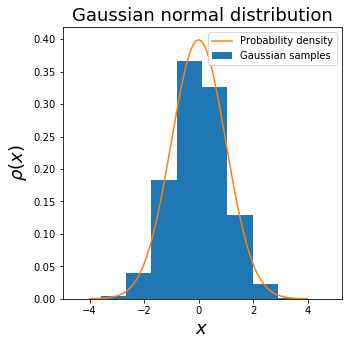

In [7]:
h = 1e-5
N = int(8 / h)
x = linspace(-4, 4, N)
G = randn(N)

plt.figure(figsize=(5, 5))
plt.hist(G, normed=True, align=u'mid', label=r'Gaussian samples')
plt.plot(x, exp(- x ** 2 / 2) / sqrt(2 * pi), label='Probability density')
plt.title('Gaussian normal distribution', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$\rho(x)$', fontsize=18)
plt.legend(loc='best')
plt.show()

## 2 Gaussian white noise and Brownian motion

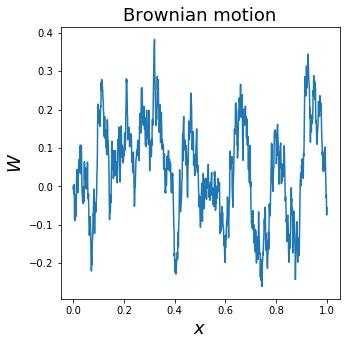

In [8]:
h = 1e-3
N = int(1 / h)
x = linspace(0, 1, N)
# Gaussian white noise
dW = randn(N) * sqrt(h)
# Brownian motion
W = cumsum(dW)


plt.figure(figsize=(5, 5))
plt.plot(x, W)
plt.title('Brownian motion', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$W$', fontsize=18)
plt.show()

## 3 A simple random matrix test function

In [9]:
def cmp_A(A, x):
    res = full_like(A, 0.0)
    m = len(A)
    n = len(A[0])
    for i in range(m):
        for j in range(n):
            if A[i, j] < x:
                res[i, j] = 1.0
    
    return res

In [10]:
# mean number
trials = 20000
N = 20
v = 0
for i in range(trials):
    A = randn(N, N)
    
    # method 1
    A = A < 0.5
    A = A.astype(float64)
    # method 2
    #A = cmp_A(A, 0.5)
    # method 3
    #A = randint(2, size=(N, N))
    #A = A.astype(float64)
    
    # entries ±1 with equal probability
    A = 2 * A - 1
    # Q is a random orthogonal matrix
    Q = qr(randn(N, N))[0]
    # rotated by Q
    A = dot(Q, A)
    v += (A[0, 0] * A[1, 1]) ** 2 - 1
print v / trials

0.00248567952243


## 4 Longest Increasing Subsequences (LIS)

In the language of probability theory, we take a uniform random permutation $\pi$ of {1, 2, ..., n}. We say that $\pi(i_1)$, ..., $\pi(i_k)$ is an increasing subsequence in $\pi$ if $i_1$ < $i_2$ < ... < $i_k$ and $\pi(i_1)$ < $\pi(i_2)$ < ... < $\pi(i_k)$. Let $l_n(\pi)$ be the length of the longest increasing subsequence.

There is an interesting link between the **moments of the eigenvalues of Q** and the number of permutations of length n with longest increasing subsequence less than or equal to length k. 

For example:

+ the permutation (5 1 3 2 4) has (1 2 4) and (1 3 4) as the longest increasing subsequences of length 3.

+ the permutation (3 1 8 4 5 7 2 6 9 10) has (1 4 5 7 9 10) and (1 4 5 6 9 10) as the longest increasing subsequences of length 6.

### Random matrix approach

$$\mathbb{P}(l_n \le k) = \frac{1}{n!} \int_{U_k} |Tr(Q)|^{2n} dQ$$

where dQ denotes normalized Haar measure on the unitary group $U_k$ of k × k matrices Q.

see, Rains, Odlyzko, Deift, Baik, Johansson, Diaconis, et al.

In [11]:
n = 4
k = 2
trials = 30000

res = []
for i in range(trials):
    A = randn(k, k) + randn(k, k) * 1j
    # QR algorithm does not guarantee nonnegative diagonal entries in R
    Q = qr(A)[0]
    #R = qr(A)[1]
    # obtain a Haar-distributed unitary matrix
    #Q = dot(Q, diag(sign(diag(R))))
    # a simple correction by randomly perturbing the phase
    Q = dot(Q, diag(exp(2 * pi * 1j * rand(k))))
    res.append(abs(trace(Q)) ** (2 * n))
mean(res)

14.056943736932952

### [Patience sorting](https://en.wikipedia.org/wiki/Patience_sorting)

> One-person card games are called **solitaire games** in American and **patience games** in British.

+ [Algorithm Implementation/Sorting/Patience sort](https://en.wikibooks.org/wiki/Algorithm_Implementation/Sorting/Patience_sort)

In [12]:
import bisect, heapq

In [13]:
def patiencesort(seq):
    piles = []
    for x in seq:
        new_pile = [x]
        i = bisect.bisect_left(piles, new_pile)
        if i != len(piles):
            piles[i].insert(0, x)
        else:
            piles.append(new_pile)
    print "longest increasing subsequence has length =", len(piles)

    # priority queue allows us to retrieve least pile efficiently
    for i in range(len(seq)):
        small_pile = piles[0]
        seq[i] = small_pile.pop(0)
        if small_pile:
            heapq.heapreplace(piles, small_pile)
        else:
            heapq.heappop(piles)
    assert not piles

In [14]:
foo = [4, 65, 2, 4, -31, 0, 99, 1, 83, 782, 1]
patiencesort(foo)
print foo

longest increasing subsequence has length = 5
[-31, 0, 1, 1, 2, 4, 4, 65, 83, 99, 782]


## 5 Wigner's semi-circle law

[随机矩阵引论：理论与实践](https://github.com/brucejunlee/RMT_Theory_Applications/blob/master/RM_introduction_python.ipynb): Chapter 1, 3, 5

## 6 Finite semi-circle law

+ The weight function of GUE:

$$w(x) = e^{- x^2 / 2}$$

+ The weight function of LUE:

$$w(x) = x^a e^{- x / 2}$$

+ **Hermite polynomial**:

$$
H_k(x) =
\begin{cases}
1, & k = 0 \\
x, & k = 1 \\
x H_{k - 1}(x) - (k - 1) H_{k-2}(x), & k \ge 2
\end{cases}
$$

[随机矩阵引论：理论与实践](https://github.com/brucejunlee/RMT_Theory_Applications/blob/master/RM_introduction_python.ipynb): Chapter 12

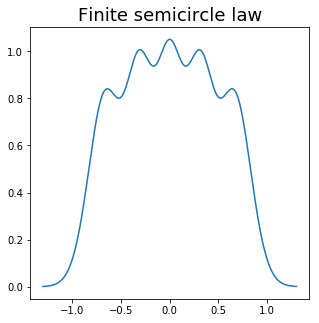

In [15]:
n = 5
# Christoffel-Darboux formula
x = linspace(-1, 1, 1000)
x = x * sqrt(2 * n) * 1.3
x = array(x, dtype=float64)

# -1st Hermite polynomial
H_old = 0 * x
# 0th Hermite polynomial
H = 1 + 0 * x

for i in range(n):
    H_new = (sqrt(2) * x * H - sqrt(i) * H_old) / sqrt(i + 1)
    H_old = H
    H = H_new
    
H_new = (sqrt(2) * x * H - sqrt(n) * H_old) / sqrt(n + 1)

# page 420 of Mehta's
k = n * H ** 2 - sqrt(n * (n + 1)) * H_new * H_old
# correct normalization multiplied
k = k * exp(- x * x) / sqrt(pi)
k = array(k, dtype=float64)

# rescale on [-1, 1] and the area is π/2
plt.figure(figsize=(5, 5))
plt.plot(x / sqrt(2 * n), k * pi / sqrt(2 * n))
plt.title('Finite semicircle law', fontsize=18)
plt.show()

## 7 Consecutive spacings of the eigenvalues of Hermitian random matrices

### GOE

+ Nearest neighborhood spacings:

$$\Delta = \lambda_{k + 1}-\lambda_k$$

> We can study Next-Nearest neighborhood spacings as well.

+ **Wigner surmise**:

$$P(s) = \frac{\pi s}{2} e^{- \frac{\pi s^2}{4}}$$

where s denotes the spacings.

[随机矩阵引论：理论与实践](https://github.com/brucejunlee/RMT_Theory_Applications/blob/master/RM_introduction_python.ipynb): Chapter 2

### GUE (Edelman & N. R. Rao, 2005)

+ It's related to **$Painlev\acute{e}$ V equation** and **zeros of Riemann $\zeta$ function**.

## 8 Mar$\check{c}$enko-Pastur law

Eigenvalues distribution of **sample covariance matrices**, namely, singular value distribution of initial Gaussian matrices.

+ A singular Mar$\check{c}$enko-Pastur distribution:

$$d_{\mu_{MP}}(x) = \frac{\sqrt{4 - x}}{2 \pi \sqrt{x}} dx$$

[随机矩阵引论：理论与实践](https://github.com/brucejunlee/RMT_Theory_Applications/blob/master/RM_introduction_python.ipynb): Chapter 13, 14

## 9 Stochastic differential operator (Sutton & Edelman)

### Hermite

+ Soft edge on the right: 

$$A + \frac{2}{\sqrt{\beta}} W$$

$$\frac{d^2}{dx^2} - x + \sigma dW$$

approximate **Airy operator** A by $\frac{1}{h^2} D_2 - diag(x_1, \dots, x_n)$ and $\frac{2}{\sqrt{\beta}} W$ by $\frac{2}{\sqrt{\beta}} \frac{1}{\sqrt{h}} diag(G_1, \dots, G_n)$ with n = 200, $h = n^{-1/3}$, $x_k = hk$, and $G_1, \dots, G_n$ are i.i.d. standard Gaussians, and over $10^5$ trials.

### Jacobi (smallest singular value)

+ hard edge on the left:

(use forward differences)

$$\tilde{J}_a + \sqrt{\frac{2}{\beta}} \frac{1}{\sqrt{y}} W$$

approximate **Bessel operator** in Liouville form by $-\frac{1}{h} D_1 + (a + \frac{1}{2}) diag(\frac{1}{y_1}, \dots, \frac{1}{y_n})$ and random term by $\sqrt{\frac{2}{\beta}} diag(\frac{1}{\sqrt{y_1}}, \dots, \frac{1}{\sqrt{y_n}}) (\frac{1}{\sqrt{h}} diag(G_1, \dots, G_n)) (\frac{1}{2} (- \Omega D_1 \Omega))$ with n = 2000, $h = \frac{1}{n}$, $y_k = hk$, and $G_1, \dots, G_n$ i.i.d. standard Gaussians, and over $10^5$ trials.

**Note**: The averaging matrix $\frac{1}{2} (- \Omega D_1 \Omega)$ splits the **noise** over two diagonals instead of one.

+ hard edge on the right:

$$\tilde{J}_b + \sqrt{\frac{2}{\beta}} \frac{1}{\sqrt{y}} W$$

approximate **Bessel operator** in Liouville form by and random term by with n = 200, $h = \frac{1}{n + \frac{a + b + 1}{2}}$, $x_k = hk$, and $G_1, \dots, G_n$ i.i.d. standard Gaussians, and over $10^5$ trials.

### Square Laguerre (smallest singular value)

+ hard edge on the left:

$$J_a + \frac{2}{\sqrt{\beta}} W$$

in which the Bessel operator has **type I BCs**.

approximate **Bessel operator** in Liouville form by $- 2 diag(\sqrt{x_1}, \dots, \sqrt{x_n}) (\frac{1}{h} D_1) + a diag(\frac{1}{\sqrt{x_1}}, \dots, \frac{1}{\sqrt{x_n}})$ and random term by $\frac{2}{\sqrt{\beta}} (\frac{1}{2} (- \Omega D_1 \Omega)) (\frac{1}{\sqrt{h}} diag(G_1, \dots, G_n))$ with n = 2000, $h = \frac{1}{n}$, $x_k = hk$, and $G_1, \dots, G_n$ i.i.d. standard Gaussians, and over $10^5$ trials.

### Rectangular Laguerre

+ hard edge on the left:

$$J_{a - 1} + \frac{2}{\sqrt{\beta}} W$$

in which the Bessel operator has **type II BCs**.

approximate **Bessel operator** in Liouville form by and random term by with n = 200, $h = \frac{1}{n + \frac{a + 1}{2}}$, $x_k = hk$, and $G_1, \dots, G_n$ i.i.d. standard Gaussians, and over $10^5$ trials.

### Bulk (spacing distribution of the gap between eigenvalues m and m+1)

+ Jacobi near one-half

### Hermite near zero

+ For even case (2m $\times$ 2m), sine operators have **type I BCs**:

$$J_{-\frac{1}{2}} + \frac{2}{\sqrt{2 \beta}} W$$

approximate $J_{-\frac{1}{2}}$ by $- 2 diag(\sqrt{x_1}, \dots, \sqrt{x_m}) (\frac{1}{h} D_1) - \frac{1}{2} diag(\frac{1}{\sqrt{x_1}}, \dots, \frac{1}{\sqrt{x_m}})$; approximate $W_{11}, W_{22}$ by $\frac{1}{\sqrt{h}} diag(G_1, \dots, G_m)$; approximate $W_{12}$ by $\frac{1}{\sqrt{h}} diag(G, \dots, G) \frac{1}{2} (- \Omega D_1 \Omega)$ with m = 200, $h = \frac{1}{m}$, $x_k = hk$.

+ For odd case ((2m + 1) $\times$ (2m + 1)), Bessel operators have **type II BCs**.

### Tracy-Widom law (Edelman & N. R. Rao, 2005)

$$L^{\beta} = \frac{d^2}{dx^2} - x + \frac{2}{\sqrt{\beta}} dW$$

## 10 Girko's circle law

Take an n$\times$n matrix with independent entries of standard deviation $n^{-1/2}$ and you'll find that its eigenvalues fill the **complex unit disk uniformly** - exactly so in the limit $m \rightarrow \infty$.

[Beyond Girko's Law](https://github.com/brucejunlee/RMT_Theory_Applications/blob/master/beyond_Girko_law.ipynb): Chapter 1

## 11 Girko's elliptic law

[Beyond Girko's Law](https://github.com/brucejunlee/RMT_Theory_Applications/blob/master/beyond_Girko_law.ipynb): Chapter 5


## 12 Simple ring law 

[Beyond Girko's Law](https://github.com/brucejunlee/RMT_Theory_Applications/blob/master/beyond_Girko_law.ipynb): Chapter 6

## 13 Eigenvalues distribution of non-Hermitian random matrices


+ Real eigenvalues: **Uniform distribution**

6056


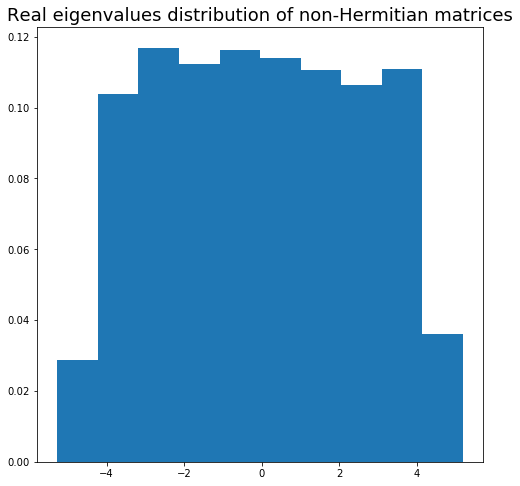

In [16]:
N = 50
trials = 1000
E = []
total = 0
for _ in range(trials):
    G = (rand(N, N) - 0.5) * 2   
    es = eigvals(G)
    for e in es:
        if e.imag == 0:
            total += 1
            E.append(e.real)

print total
E = array(E)
plt.figure(figsize=(8, 8))
plt.hist(E, normed=True)
plt.title('Real eigenvalues distribution of non-Hermitian matrices', fontsize=18)
plt.show()

+ Complex eigenvalues: Scaled **imaginary parts**

10000


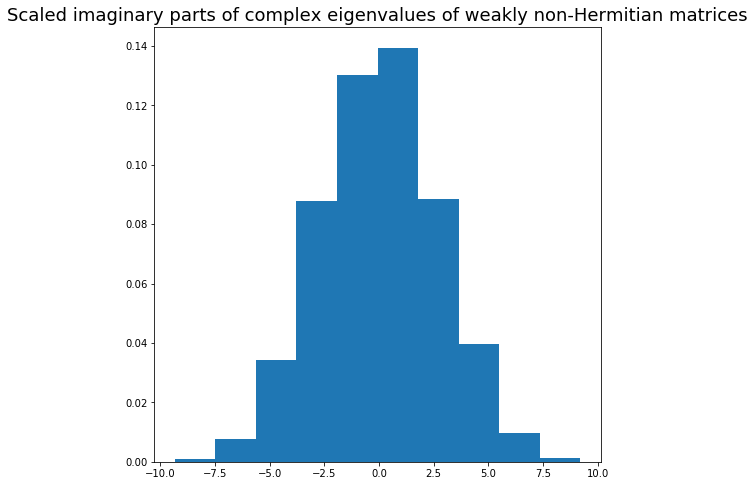

In [17]:
N = 10
trials = 1000
E = []
v = 1 / sqrt(N)
total = 0
for _ in range(trials):
    G1 = randn(N, N) + 1j * randn(N, N)
    G1 = mat(G1)
    A = (G1 + G1.H) / 2                         # GUE E(trA^2)=N^2 
    G2 = randn(N, N) + 1j * randn(N, N)
    G2 = mat(G2)
    B = (G2 + G2.H)/2                           # GUE E(trB^2)=N^2
    J = (A + 1j * v * B) / sqrt(N)     
    es = eigvals(J)
    for e in es:
        if e.imag != 0:
            total += 1
            # scaled imaginary parts
            E.append(2 * N * e.imag)

print total
E = array(E)
plt.figure(figsize=(8, 8))
plt.hist(E, normed=True)
plt.title('Scaled imaginary parts of complex eigenvalues of weakly non-Hermitian matrices', fontsize=18)
plt.show()

## 14 Tracy-Widom law


+ Extreme eigenvalues distribution (**edge distribution** or largest eigenvalue distribution)

> The largest eigenvalue distribution of Hermite ensemble and Laguerre ensemble $\sim$ Tracy-Widom law in **different normalization constants**.

+ $\beta$-Hermite ensemble: **Tracy & Widom, 2008**
+ $\beta$-Laguerre ensemble:
    + $\beta$ = 1: **Johnstone, 2001**
    + $\beta$ = 2: **Johansson, 2000**

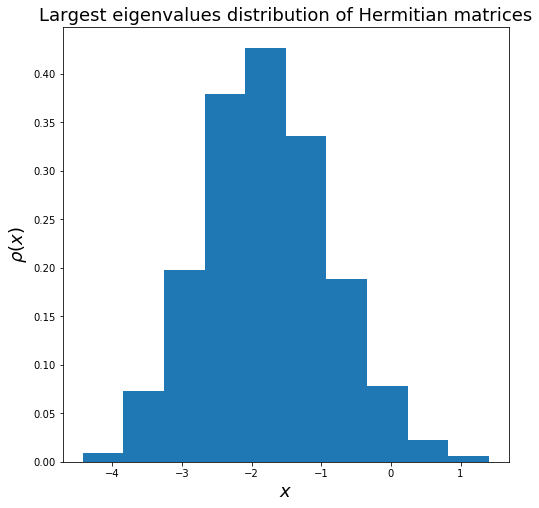

In [18]:
N = 40
trials = 5000
E = []
for i in range(trials):
    A = randn(N, N) + randn(N, N) * 1j
    A = mat(A)
    A = (A + A.H) / 2
    E.append(sorted(eigvalsh(A))[-1])

E = array(E)
# normalization
E = N ** (1 / 6) * (E - 2 * sqrt(N))
plt.figure(figsize=(8, 8))
plt.hist(E, normed=True)
plt.title('Largest eigenvalues distribution of Hermitian matrices', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$\rho(x)$', fontsize=18)
plt.show()

+ **Limiting** Tracy-Widom density

> Theoretical probability density function is related to the solution of **$Painlev\acute{e}$ II equation**:

$$q^{\prime \prime} = s q + 2 q^3$$

with the **BCs** $q(s) \sim Ai(s)$ as $s \rightarrow \infty$.

The probability distributions thus obtained are the famous **Tracy-Widom** distributions.

The probability distribution $f_2(s)$, corresponding to $\beta = 2$, is given by

$$f_2(s) = \frac{d}{ds} F_2(s),$$

where

$$F_2(s) = \exp(- \int_s^{\infty} (x - s) q(x)^2 dx).$$

The probability distributions $f_1(s)$ and $f_4(s)$ for $\beta = 1$ and $\beta = 4$ are the derivatives of $F_1(s)$ and $F_4(s)$ respectively, which are given by

$$F_1(s)^2 = F_2(s) \exp(- \int_s^{\infty} q(x) dx)$$

and

$$F_4(\frac{s}{2^{\frac{2}{3}}})^2 = F_2(s) (cosh(\int_s^{\infty} q(x) dx))^2.$$

更多特殊函数查阅[scipy.special](https://docs.scipy.org/doc/scipy-0.16.1/reference/special.html)

> The **trapezoidal rule** cumsum function is used to approximate numerically the integrals.

> To solve this equation with **odeint**, we must first convert it to **a system of first order equations**.

$$\frac{d}{ds} \begin{pmatrix} q \\ p \end{pmatrix} =$$

$$\begin{pmatrix} p \\ s q + 2 q^3 \end{pmatrix}.$$

Let y be the vector [q, p].

**Note**: A system of first order equations can be constructed in another form to simplify the computation.

In [19]:
def PII(y, s):
    q, p = y
    dyds = [p, s * q + 2 * q ** 3]
    return dyds

/Users/brucelee/miniconda2/lib/python2.7/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


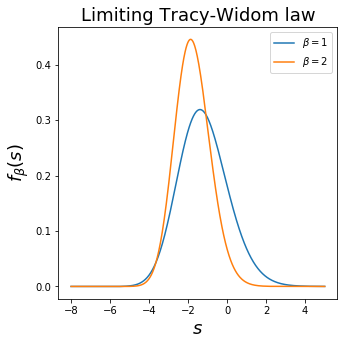

In [20]:
# right endpoint
s0 = 5
# left endpoint
sn = -8
# initial conditions
y0 = [airy(s0)[0], airy(s0)[1]]
sspan = linspace(s0, sn, 1000)
y = odeint(PII, y0, sspan)
q = y[:, 0]

dI0 = I0 = J0 = 0
dI = - cumsum((q[:-1] ** 2 + q[1:] ** 2) / 2 * diff(array(sspan))) + dI0
dI = array([0] + list(dI))
I = - cumsum((dI[:-1] + dI[1:]) / 2 * diff(array(sspan))) + I0
I = array([0] + list(I))
J = - cumsum((q[:-1] + q[1:]) / 2 * diff(array(sspan))) + J0
J = array([0] + list(J))

F2 = exp(-I)
f2 = gradient(F2, sspan)
F1 = sqrt(F2 * exp(-J))
f1 = gradient(F1, sspan)
#F4 = sqrt(F2) * cosh(J / 2)
#s4 = sspan / (2 ** (2 / 3))
#f4 = gradient(F4, s4)

plt.figure(figsize=(5, 5))
plt.plot(sspan, f1, label=r'$\beta = 1$')
plt.plot(sspan, f2, label=r'$\beta = 2$')
#plt.plot(sspan, f4, label=r'$\beta = 4$')
plt.title('Limiting Tracy-Widom law', fontsize=18)
plt.xlabel(r'$s$', fontsize=18)
plt.ylabel(r'$f_{\beta}(s)$', fontsize=18)
plt.legend(loc='best')
plt.show()

## 15 Faster Tracy-Widom law

+ Using **symmetric tridiagonal matrix**

$$H_n^{\beta} \sim \frac{1}{\sqrt{2}} \begin{pmatrix} \mathcal{N}(0, 2) & \chi_{(n - 1)\beta} & \qquad & \qquad & \qquad \\ \chi_{(n - 1)\beta} & \mathcal{N}(0, 2) & \chi_{(n - 2)\beta} & \qquad & \qquad \\ \qquad & \ddots & \ddots & \ddots & \qquad \\ \qquad & \qquad & \chi_{2 \beta} & \mathcal{N}(0, 2) & \chi_{\beta} \\ \qquad & \qquad & \qquad & \chi_{\beta} & \mathcal{N}(0, 2) \end{pmatrix}$$

We call it **$\beta$-Hermite ensemble**.

+ The observation that if $k = 10 n^{1/3}$, then the largest eigenvalue is determined numerically by the top $k \times k$ segment of n. (This is related to the decay of the **Airy function** that arises in the kernel whose eigenvalues determine the largest eigenvalue distribution. The **'magic number'** 10 here is not meant to be precise. It approximates the index k such that $\frac{v(k)}{v(1)} \approx \epsilon$, where $\epsilon$ = $2^{-52}$ for double precision arithmetic, and v is the eigenvector corresponding to the largest eigenvalue. For small $\beta$, it may be necessary to crank up the number 10 to a larger value.)

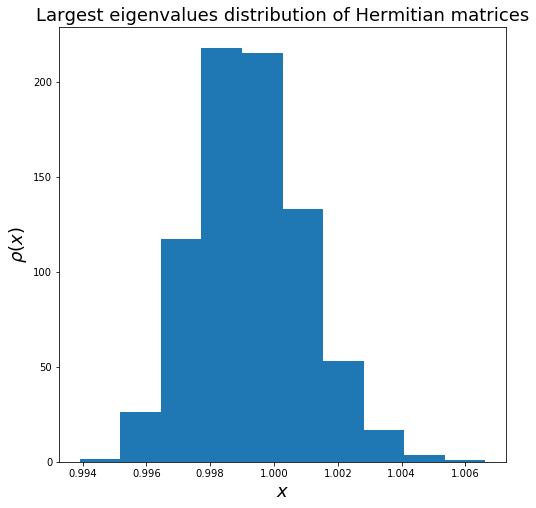

In [21]:
n = 1e4
E = []
trials = 10000
alpha = 10
# real
beta = 1
# cutoff parameters
k = int(round(alpha * n ** (1 / 3)))

for i in range(trials):
    d1 = sqrt(chisquare(array([j * beta for j in range(int(n - 1), int(n - k), -1)])))
    d0 = randn(k)
    H = diag(d1, 1) + diag(d0)
    # scale so largest eigenvalues is near 1
    H = (H + H.T) / sqrt(4 * n * beta)
    E.append(sorted(eigvalsh(H))[-1])
    
E = array(E)
plt.figure(figsize=(8, 8))
plt.hist(E, normed=True)
plt.title('Largest eigenvalues distribution of Hermitian matrices', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$\rho(x)$', fontsize=18)
plt.show()

## 16 $\beta$-Ensembles with Covariance

+ **Alexander Dubbs** (PhD Thesis, MIT 2014, doctoral advisor: **Alan Edelman**)

### $\beta$-Wishart (Recursive) Model

+ Broken-Arrow Matrix

In [22]:
def betaWishart(m, n, beta, D):
    Z = zeros((n, n), dtype=complex)
    if n == 1:
        return sqrt(chisquare(m * beta)) * sqrt(D[0, 0])
    else:
        Z[:-1, :-1] = betaWishart(m, n - 1, beta, D[:-1, :-1])
        Z[-1, :-1] = zeros(n - 1)
        Z[:-1, -1] = array([sqrt(chisquare(beta)) * sqrt(D[-1, -1]) for _ in range(n-1)])
        Z[-1, -1] = sqrt(chisquare((m - n + 1) * beta)) * sqrt(D[-1, -1])
        return diag(svd(Z)[1])

In [23]:
# m > (n - 1)
m = 4
n = 3
beta = 1
D = ones((n, n))
betaWishart(m, n, beta, D)

array([[ 2.78189623,  0.        ,  0.        ],
       [ 0.        ,  1.18569805,  0.        ],
       [ 0.        ,  0.        ,  0.62989843]])

### $\beta$-MONOVA Model

Given $X_{m \times n}$, $Y_{p \times n}$ and $\Omega_{n \times n}$ is diagonal & real, then $\Omega X^{\ast} X \Omega$ have **eigendecomposition**:

$$U \Lambda U^{\ast},$$
    
and $\Omega X^{\ast} X \Omega (Y^{\ast}Y)^{-1}$ have **eigendecomposition**

$$V M V^{\ast}.$$

Then,

$$(C, S) = gsvd_C (Y, X\Omega) = (M + I)^{- \frac{1}{2}}$$

$\Omega X^{\ast} X \Omega (Y^{\ast}Y)^{-1} \sim \Lambda U^{\ast}(Y^{\ast}Y)^{-1}U \sim \Lambda ((U^{\ast}Y^{\ast})(YU))^{-1} \sim \Lambda (Y^{\ast}Y)^{-1}$

In [24]:
def betaMANOVA(m, n, p, beta, Omega):
    L = betaWishart(m, n, beta, dot(Omega, Omega))
    M = inv(betaWishart(p, n, beta, inv(L)))
    return sqrtm(M + eye(n))

In [25]:
m = 4
p = 5
n = 3
beta = 1
Omega = ones((n, n))
betaMANOVA(m, n, p, beta, Omega)

array([[ 1.25281928,  0.        ,  0.        ],
       [ 0.        ,  1.39730984,  0.        ],
       [ 0.        ,  0.        ,  3.38615502]])

## 17 Smallest eigenvalues distribution (Terence Tao, 2010)


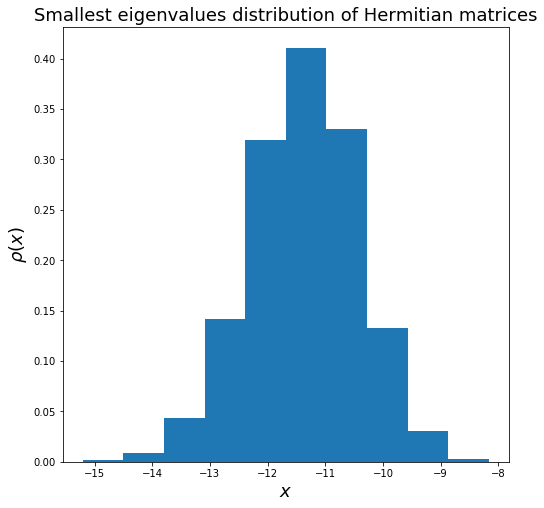

In [26]:
N = 6
trials = 10000
E = []
for i in range(trials):
    A = randn(N, N) + randn(N, N) * 1j
    A = mat(A)
    A = (A + A.H) / 2
    E.append(sorted(eigvalsh(A))[0])

E = array(E)
# normalization
E = N ** (1 / 6) * (E - 2 * sqrt(N))
plt.figure(figsize=(8, 8))
plt.hist(E, normed=True)
plt.title('Smallest eigenvalues distribution of Hermitian matrices', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$\rho(x)$', fontsize=18)
plt.show()

+ **Bidiagonalization (Alan Edelman, 2003)**

The bidiagonal of $\chi$'s can be viewed as a discretization of a **stochastic Bessel operator** 

$$- \sqrt{x} \frac{d}{dx} + \frac{1}{\sqrt{2}} dW,$$

where $dW$ denotes some white noise.

$$\chi_k \approx \sqrt{k} + \frac{1}{\sqrt{2}}G$$

We use k $\times$ k $\chi$'s in the bottom and Gaussians for the rest.

+ Some random matrix statistics of the **multivariate hypergeometric functions** are the largest and smallest eigenvalue of a **Wishart matrix**.

For example, the Wishart matrix can be written as 

$$L_n^{\beta} = B_n^{\beta} B_n^{\beta T},$$

where

$$B_n^{\beta} = \begin{pmatrix} \chi_{2 a} & \qquad & \qquad & \qquad \\ \chi_{(n - 1)\beta} & \chi_{2 a - \beta} & \qquad & \qquad \\ \qquad & \ddots & \ddots & \qquad \\ \qquad & \qquad & \chi_{\beta} & \chi_{2 a - (n - 1) \beta} \end{pmatrix},$$

where $a > \frac{\beta}{2} (n - 1)$.

We call it **$\beta$-Laguerre ensemble**.

The probability density function of the smallest eigenvalue of the Wishart matrix is

$$p(x) = x^9 e^{- \frac{3x}{2}} {_{2}F_0^1}(3, 4; ;-2 \frac{I_2}{x})$$

and

$$f(x) = x^{kn} e^{- \frac{n x}{2}} {_{2}F_0^{2 / \beta}}(-k, \beta \frac{n}{2} + 1;;- \frac{2}{x}I_{n - 1}),$$

where $k = a - (n - 1)\frac{\beta}{2} -1$ is a nonnegative integer.

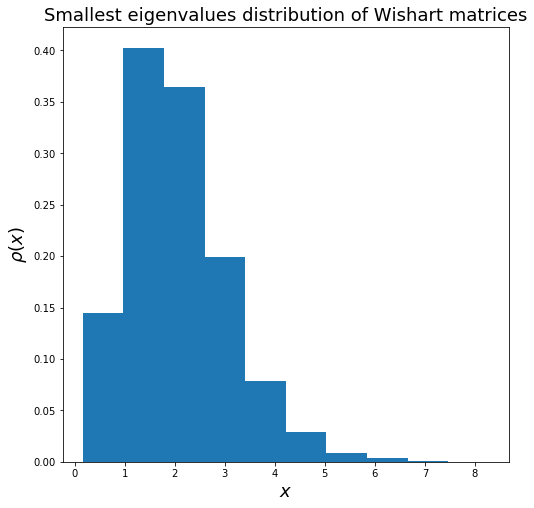

In [27]:
N = 5
trials = 10000
beta = 6
#beta = 0.5
a = 16
#a = 5
E = []
for i in range(trials):
    d1 = sqrt(chisquare(array([j * beta for j in range(int(N - 1), 0, -1)])))
    d0 = sqrt(chisquare(array([2 * a - j * beta for j in range(N)])))
    B = diag(d1, -1) + diag(d0)
    L = dot(B, B.T)
    E.append(sorted(eigvalsh(L))[0])

E = array(E)
plt.figure(figsize=(8, 8))
plt.hist(E, normed=True)
plt.title('Smallest eigenvalues distribution of Wishart matrices', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$\rho(x)$', fontsize=18)
plt.show()

## 18 Expected number of real eigvalues (Alan Edelman, 1993)

$$\lim_{n \rightarrow \infty} \frac{E_n}{\sqrt{n}} = \sqrt{\frac{2}{\pi}}$$ 

where $E_n$ denotes the **expected number of real eigvalues of standard normalized random matrices** uniformly distributed in [-1, 1].

+ **Multivariate hypergeometric functions** are used in the proof of this theorem.

In [28]:
ns = [1, 100, 200, 300, 400, 500]
trials = 100
print r'n    trials    exprimental En    theoretical En    time(sec)'
for n in ns:
    t1 = time()
    E = []
    for i in range(trials):
        A = randn(n, n)
        es = eigvals(A)
        total = 0
        for e in es:
            if e.imag == 0:
                total += 1
        E.append(total)
    E = array(E)
    t2 = time()
    print n, '   ', trials, '       ', mean(E), '          ', sqrt(2 * n / pi), '    ', t2 - t1

n    trials    exprimental En    theoretical En    time(sec)
1     100         1.0            0.797884560803      0.00756788253784
100     100         8.26            7.97884560803      0.63876414299
200     100         11.6            11.283791671      4.13122200966
300     100         14.36            13.8197659789      10.0522580147
400     100         16.4            15.9576912161      18.7795391083
500     100         18.74            17.8412411615      29.6070139408


## 19 Quarter-circle law

+ **singular values** distribution of Gaussian random matrices:

$$\lim_{m \rightarrow \infty} \frac{m \beta}{n} = \gamma \leq 1.$$

When $\gamma = 1$, by making the change of variables $x = y^2$, one obtains the well-known **quarter-circle law** for the singular values of a matrix from $G^{\beta}(n, n)$.

+ The minimum sigular value of an $N \times N$ standard complex Gaussian matrix H satisfies **(Alan Edelman, 1989; Jianhong Shen(Minnesota), 2001)**

$$\lim_{N \rightarrow \infty} P[N \sigma_{min} > x] = e^{- x - \frac{x^2}{2}}$$

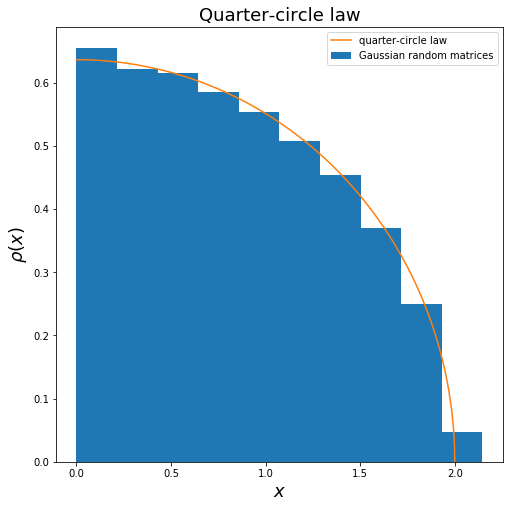

In [29]:
m = n = 50
trials = 1000
V = []
a = 0
b = 2
x = linspace(a, b, 1000)
for i in range(trials):
    A = randn(m, n)
    vs = svd(A)[1]
    for v in vs: 
        V.append(v)

V = array(V)
# normalization
V = V / sqrt(m)

plt.figure(figsize=(8, 8))
plt.hist(V, normed=True, label='Gaussian random matrices')
plt.plot(x, sqrt(4 - x ** 2) / pi, label='quarter-circle law')
plt.title('Quarter-circle law', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$\rho(x)$', fontsize=18)
plt.legend(loc='best')
plt.show()

## 20 Condition number distribution

+ **John von Neumann**

+ **G. Birkhoff**, **S. Smale** and Demmel

+ [Alan Edelman](http://math.mit.edu/~edelman/): **Eigenvalues and Condition Numbers of Random Matrices** (PhD Thesis, 1989)

$$\lim_{n \rightarrow \infty} P(\frac{\kappa}{n} < x) = e^{- \frac{2}{x} - \frac{2}{x^2}}$$

The condition number $\kappa$ is defined as the ratio of the largest to smallest singular values:

$$\kappa = \lVert A \rVert \lVert A^{-1} \rVert = \frac{\sigma_{max}}{\sigma_{min}}$$

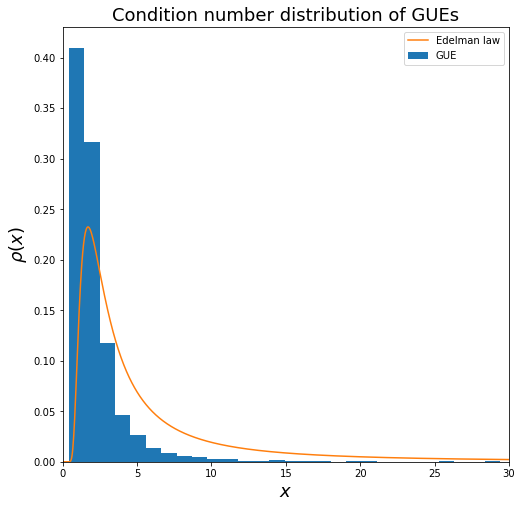

In [30]:
n = 20
trials = 5000
C = []
eps = 1e-10
for i in range(trials):
    A = randn(n, n) + randn(n, n) * 1j
    A = mat(A)
    A = (A + A.T) / (4 * sqrt(n))
    C.append(cond(A) / n)
    
C = array(C)
num_bins = 100
x = linspace(0, 30, 1000)
plt.figure(figsize=(8, 8))
plt.hist(C, bins=num_bins, normed=True, label='GUE')
plt.plot(x, (2 * x + 4) * exp(- 2 / (x + eps) - 2 / (x + eps) ** 2) / (x + eps) ** 3, label='Edelman law')
plt.title('Condition number distribution of GUEs', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$\rho(x)$', fontsize=18)
plt.xlim(0, 30)
plt.legend(loc='best')
plt.show()

## 21 Log determinant

The **log-determinant of a Wigner matrix** is a **linear statistic of its singular value**, i.e., the sum of the logarithm of the singular values: $$\log(\lvert det(H_n)\rvert)=2\Sigma_{k=1}^n \log(\sigma_k)$$

+ For the non-Hermitian case, due to the **instability of the spectrum** for such matrices, we need to work with the log-determinants $\log \lvert det(M_n-z_0) \rvert$ rather than with the **Stieltjes transform** $\frac{1}{n}trace(M_n-z_0)^{-1}$ in order to exploit **Girko's Hermitization method**.

> Terence Tao & Van Vu. **Random matrices: universality of local spectral statistics of non-hermitian matrices**.

In [31]:
A = randn(5, 5)
A = (A + A.T) / 2
logdet = slogdet(A)[1]
print logdet

0.394460274815


## 22 Partition the singular values of $GUE_n$

$$GUE_{\infty} = LUE_{\infty} \cup LUE_{\infty}$$

$$GUE_7 = LUE_3^{\frac{1}{2}} \cup LUE_4^{-\frac{1}{2}}$$

+ **Alan Edelman**, 2015, [The Singular Values of the GUE (Less is More)](http://www-math.mit.edu/~edelman/publications/singular_values.pdf)

+ We probabilistically un-mix singular values sampled from the $n \times n$ **GUE** to produce samples distributed as the union of two **Laguerre ensembles**.

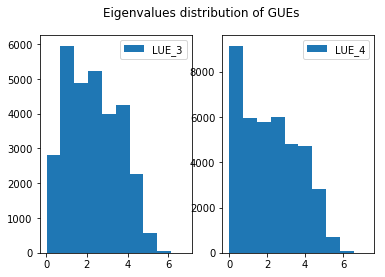

In [32]:
# number of samples
trials = 10000
# n = order of GUE
n = 7
mid_left = int(floor(n / 2))
mid_right = int(ceil(n / 2))
outlist = zeros((trials, n))
# We need a list of all partitions of {1, 2, ..., n} into two balanced parts.
# We generate all subsets of size floor(n / 2) and their complements.

# a central binomial coefficient
cbinom = int(comb(n, mid_left))
# subsets of {0, 1, ..., n - 1}
parta = array([c for c in combinations(range(n), mid_left)])
# their complements
partb = zeros((cbinom, mid_right), dtype=int64)

for prep in range(cbinom):
    partb[prep, :] = array(list(set(range(n)).difference(set(parta[prep, :]))))
partitions = concatenate((parta, partb), axis=1)
P = zeros(cbinom)
                 
for rep in range(trials):
    # Sample singular values from the GUE of appropriate size
    G = randn(n, n) + randn(n, n) * 1j
    G = mat(G)
    A = (G + G.H) / 2
    eiglist = array(sorted(abs(eigvalsh(A))))
    e_n = len(eiglist)
    # We'll need the differences of the squares of the eigenvalues
    singdiffs = zeros((e_n, e_n))
    sd = eiglist ** 2 * ones(n)
    for i in range(e_n):
        singdiffs[i, :] = sd - sd[i]
    # The n eigenvalues can be partitioned in binom(n, floor(n/2)) ways. 
    # Compute the relative densities with common factors ommited.
    for prep in range(cbinom):
        P[prep] = (abs(prod(eiglist[parta[prep, :]])) / prod(singdiffs[parta[prep, :], :][:, partb[prep, :]])) ** 2
    # Separate the singular values with each partition occuring proportionally to its density
    outlist[rep, :] = eiglist[partitions[list(nonzero(cumsum(P) > rand() * sum(P))[0]), :][0]]
    
#plt.figure(figsize=(10, 10))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.hist(outlist[:, :3].flatten(), label='LUE_3')
plt.suptitle('Eigenvalues distribution of GUEs')
ax1.legend(loc='best')
ax2.hist(outlist[:, 3:].flatten(), label='LUE_4')
ax2.legend(loc='best')
plt.show()

## 23 Sturm sequences

> Efficiently compute histograms of eigenvalues for **symmetric tridiagonal matrices** (time complexity $\mathcal{O}(m n)$) and apply these ideas to random matrix ensembles such as the  $\beta$-Hermite ensemble, where n is the dimension of the matrix and m is the number of bins (with arbitrary bin centers and widths) desired in the histogram (m is usually much smaller than n).

### Definition

+ Lower right corner submatrix sequences:

$$\{A_0, A_1, \dots, A_n\}$$

+ Sturm sequences:

$$\{d_0, d_1, \dots, d_n\} = \{1, |A_1|, \dots, |A_n|\}$$

+ Sturm ratio sequences:

$$r_i = \frac{d_i}{d_{i - 1}}, i = 1 \dots n$$

### Lemma 1

> The number of **sign changes** in the Sturm sequence is equal to the number of **negative eigenvalues** of A.

### Lemma 2

> The number of **negative values** in the Sturm ratio sequence  is equal to the number of **negative eigenvalues** of A.

### Example

Given a **symmetric tridiagonal matrix** with values $(a_n, a_{n - 1}, \dots, a_1)$ on the diagonal and $(b_{n - 1}, b_{n - 2}, \dots, b_1)$ on the super/sub-diagonal, then

$$
d_i =
\begin{cases}
 1, & i = 0 \\
 a_1, & i = 1\\
 a_i d_{i-1} -b_{i-1}^2 d_{i-2}, & i \in \{2, 3, \dots, n\}
\end{cases}
$$

equivalently,

$$
r_i =
\begin{cases}
 a_1, & i = 1\\
 a_i -\frac{b_{i - 1}^2}{r_{i - 1}}, & i \in \{2, 3, \dots, n\}
\end{cases}
$$

For $H_n^\beta$, Sturm ratio sequence of $H_n^\beta - \lambda I$:

$$
r_{i, \lambda} =
\begin{cases}
 G(- \lambda, 1), & i = 1\\
 G(- \lambda, 1) - \frac{\chi_{\beta (i - 1)}^2}{2 r_{i - 1, \lambda}}, & i \in \{2, 3, \dots, n\}
\end{cases}
$$

For $i \ge 2$, the density of $r_i$ conditioned on $r_{i - 1}$ is

$$f_{r_i|r_{i - 1}}(s_i|s_{i - 1}) = \frac{|s_{i - 1}|^{p_i}}{\sqrt{2 \pi}} e^{- \frac{1}{4}[2(s_i + \lambda)^2-z_i^2]^2}D_{- p_i}(z_i)$$

where $p_i = \frac{\beta (i - 1)}{2}$ and $z_i = sign(s_{i - 1})(s_i + \lambda + s_{i - 1})$.

### Application

Separators between histogram bins:

$$\{-\infty, k_1, k_2, \dots, k_{m - 1}, \infty\}$$

Histogram sequence:

$$\{H_1, H_2, \dots, H_m\}$$

where $H_i$ is the number of eigenvalues between $k_{i - 1}$ and $k_i$ for $1 \le i \le m$.

Let $\Lambda(M)$ be the number of negative eigenvalues of a matrix M, then

$$H_1 = \Lambda(A - k_1 I),$$

and

$$H_i = \Lambda(A - k_i I) - \Lambda(A - k_{i - 1} I),i \in \{2, 3, \dots, m - 1\},$$

and

$$H_m = n - \Lambda(A - k_{m - 1} I).$$

### Reference

James T. Albrecht, Cy P. Chan and **Alan Edelman**, **Sturm sequences and random eigenvalue distributions**, Foundations of Computational Mathematics(FoCM), 2009.

In [33]:
n = 20
alpha = 10
# complex
beta = 2
E = []
trials = 1000
for i in range(trials):
    d1 = sqrt(chisquare(array([j * beta for j in range(int(n - 1), 0, -1)])))
    d0 = randn(n)
    H = diag(d1, 1) + diag(d0) + diag(d1, -1)
    H = H / sqrt(2)
    es = eigvalsh(H)
    E.append(len(es[es < 0]))
    
E = array(E)
print 'E(# negative eigenvalues): %f' % mean(E)

E(# negative eigenvalues): 9.991000


In [34]:
beta = 2
labda = 0
n = 20
num = []
trials = 1000
for j in range(trials):
    r = []
    r1 = 1
    for i in range(1, n):
        r2 = randn() -labda - chisquare(beta * i) / (2 * r1)
        r.append(r2)
        r1 = r2
    r = array(r)
    num.append(len(r[r < 0]))
num = array(num)
print 'E(# negative Sturm ratio): %f' % mean(num)

E(# negative Sturm ratio): 9.666000


## 24 Angular sychronization problem

> Suppose we want to find n **unknown angles** $\theta_1, \theta_2, \dots, \theta_n \in [0, 2 \pi)$.

> We are given $m \le \begin{pmatrix} n \\ 2 \end{pmatrix}$ "noisy" measurements $\delta_{ij}$ which are $\theta_i - \theta_j$ with probability p and uniformly chosen from $[0, 2 \pi)$ with probability 1- p. 

> Our goal is to devise a method that with high probability recovers the angles, under some conditions we impose.

**Method**:

+ **Eigenvector method**

**References**:

+ [Fast Angular Synchronization for Phase Retrieval via Incomplete Information](https://math.msu.edu/user_content/docs/FastAngularSync_ViswanthanIwen_201520150924162533237.pdf)

+ [Angular Sychronization by Spectral Methods](http://www.mit.edu/~18.338/projects/tran_slides.pdf)

## 25 [RMT and Boson computer](http://web.mit.edu/18.338/www/projects/napp_slides.pdf)

> The computer $A$ outputs a sample from a probability distribution $\mathcal{D}_A$.

> if there exists a classical algorithm that can efficiently output a sample from a distribution close to $\mathcal{D}_A$, then $P^{\#P} = BPP^{NP}$: a drastic consequence for complexity theory!

+ The distribution of determinants of some matrix ensemble:

$$det(A) = \Sigma_{j = 1 \dots n} (-1)^{i + j} a_{ij} A_{ij}$$

+ The distribution of permanent absolute values of some matrix ensemble

$$Per(A) = \Sigma_{j = 1 \dots n} a_{ij} A_{ij}$$

> Terence Tao & V. Vu; L. Valiant

+ Traditionally, the permanent computation is **NP-hard**.

+ But, using **tropical algebra** (semiring algebra), the permanent computation is changed into **#P**.

$$Per(A) = \bigoplus_{j = 1 \dots n} a_{ij} \bigotimes A_{ij}$$

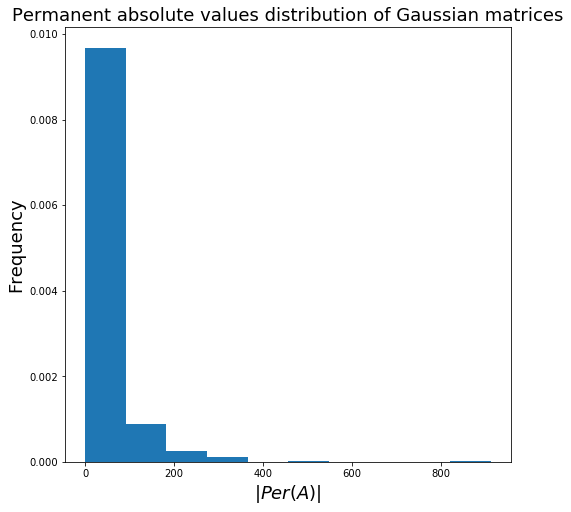

In [35]:
n = 7
trials = 1000
P = []
for i in range(trials):
    A = randn(n, n)
    P.append(abs(permanent(A)))

P = array(P)
plt.figure(figsize=(8, 8))
plt.hist(P, normed=True, label='GUE')
plt.title('Permanent absolute values distribution of Gaussian matrices', fontsize=18)
plt.xlabel(r'$|Per(A)|$', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()

## 26 Spike Model

> The popular **spiked covariance model**: in which several eigenvalues are significantly larger than all the others, which all equal 1.

+ **Stein**, 1956: **Seminal work**

+ Feral & **Peche**, 2006

+ David L. Donoho, Matan Gavish, Iain M. Johnstone, 2013: [Optimal Shrinkage of Eigenvalues in the Spiked Covariance Model](https://arxiv.org/pdf/1311.0851.pdf)


> **Loss functions**:

+ Stein Loss:

$$L^{st}(A, B) = (trace(A^{- 1} B - I) - \log (\lvert B \rvert / \lvert A \rvert)) / 2$$

Consider the matricial pivot $\Delta = A^{-1/2} B A^{-1/2}$, then

$$L^{st}(A, B) = (trace(\Delta - I) - \log \lvert \Delta \rvert) = g(\Delta)$$

+ Entropy/Divergence Loss:

$$L^{ent}(A, B) = L^{st}(B, A)$$

$$L^{div}(A, B) = L^{st}(A, B) + L^{st}(B, A) = \frac{1}{2}[trace(A^{-1} B - I) + trace(B^{-1} A - I)]$$

+ Bhattarcharya/Matusita Affinity:

$$L^{aff} = \frac{1}{2} \log \frac{\lvert A + B \rvert / 2}{\lvert A \rvert^{1/2} \lvert B \rvert^{1/2}}$$

Using the pivot $\Delta = A^{-1/2} B A^{-1/2}$, then

$$L^{aff} = \frac{1}{4} \log(\lvert 2 I + \Delta + \Delta^{-1} \rvert /4)$$

+ Frechet Discrepancy:

$$L^{fre}(A, B) = trace(A + B - 2 A^{1/2} B^{1/2})$$

Using the pivot $\Delta = A^{1/2} - B^{1/2}$, then

$$L^{fre} = trace(\Delta^2)$$

+ Squared Error Loss:

$$L^{F, 1}(A, B) = \lVert A - B \rVert_F^2$$

+ Squared Error Loss on Precision:

$$L^{F, 2}(A, B) = \lVert A^{-1} - B^{-1} \rVert_F^2$$

+ Nuclear Norm Loss:

$$L^{N, 1}(A, B) = \lVert A - B \rVert_\ast$$

where $\ast$ denotes the sum of singular values.

> **Spiked Wigner matrix**:

+ $\lambda \le 1$: $\lambda_{max}(Y) \rightarrow 2$ as $n \rightarrow \infty$;

+ $\lambda > 1$: $\lambda_{max}(Y) \rightarrow \lambda + \frac{1}{\lambda} > 2$ as $n \rightarrow \infty$.

In [36]:
labda = 2.0
n = 1000
x = zeros(n)
x[0] = 1
x = permutation(x)
x = x.reshape(n, 1)
A = randn(n, n)
W = (A + A.T) / 2
Y = labda * dot(x, x.T) + W / sqrt(n)
e = sorted(eigvals(Y))[-1]
print e

2.27588810055


## 27 Monte Carlo sampling

For a sample $\{x_i\}_{i = 1}^K$ of **pdf** p(x):

$$\int Q(x) p(x) dx \approx \frac{1}{K} \sum_{i = 1}^K Q(x_i).$$ 